vf 07: Classificação se é fato gerador ou não e da categoria (SE, CI, CA) de uma só fez (4 categorias: NÃO, SE, CI, CA) e em 2 etapas, utilizando TF-IDF com limpeza de dados, balanceamento de classes, otimização de hiperparâmetros com cross validation do algoritimo XGBClassifier.

# Classificação de lançamentos contábeis

1) Descrição do problema: classificar a despesa pública natureza 339036 (outros serviços - pessoa física) com base no histórico da nota de empenho como fato gerador, ou não, das contribuições previdenciárias.

2) Descrição da solução: Construção de features com base no texto do histórico das notas de empenho, treinamento e teste para seleção do modelo de classificação com melhor métrica de desempenho.

3) Fonte de dados: Os dados das notas de empenho estão disponíveis em portais da transparência de diversos órgãos públicos, por exemplo,
https://www.governotransparente.com.br/acessoinfo/44529487/empenhoportipo. No caso, será utilizada uma base de dados rotulados a partir desses dados públicos.

4) Variáveis independentes: texto com o histórico da nota de empenho.

5) Variável dependente. Primeiramente, será classificado apenas como 0 (não é fato gerador) e 1 (é fato gerador). Posteriormente, a classificação incluirá a categoria do segurado: segurado empregado, contribuinte individual, contribuinte individual – condutor autônomo.

## 1. Carregamento dos dados e importação das bibliotecas

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [2]:
# Monta google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# Carrega os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importa bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.inspection import permutation_importance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler
import joblib

# Configurações
pd.set_option('display.max_colwidth', None)

In [4]:
# Importa os dados
df_completo = pd.read_json('/content/drive/My Drive/projeto classificacao de lancamento/dados/despesa liquidada - base completa - texto processado - balanceado.json')
df_completo.head()

,descricao,fato_gerador,categoria,descricao_limpa,descricao_lematizada
0,Pagamento Referente Aos Serviços De Transporte De Técnicos Durante Supervisão Escolar Nas Escolas Da Zona Rural Deste Município. Referente Ao Mês De Agosto De 2020.,Sim,CA,transporte técnicos supervisão escolar escolas deste,transporte técnico supervisão escolar escola de este
1,"Pagamento Referente Aos Serviços De Transporte De Técnicos Da Secretaria De Educação, Durante Supervisão Escolar Em Unidades Escolares Da Rede Municipal De Ensino. Referente Ao Mês De Maio De 2020.",Sim,CA,transporte técnicos educação supervisão escolar unidades escolares rede,transporte técnico Educação supervisão escolar unidade escolar rede
2,Serviços De Transporte De Infraestrutura Deste Municipio.,Sim,CA,transporte infraestrutura deste municipio,transporte infraestrutura de este municipio
3,Pagamento Referente Aos Serviços De Transporte De Materiais De Expediente Para Atender As Escolas Da Rede Municipal De Ensino.,Sim,CA,transporte materiais expediente escolas rede,transporte material expediente escola rede
4,Serviços De Transportes De Materiais Para Serviços De Infraestrutura Urbana Para Atender As Necessidades As Necessidades Município.,Sim,CA,transportes materiais infraestrutura urbana necessidades necessidades,transporte material infraestrutura urbano necessidade necessidades


In [5]:
# Construção de dataframe com as colunas de interesse
df = df_completo[['descricao_lematizada', 'fato_gerador', 'categoria']]
df.head()

,descricao_lematizada,fato_gerador,categoria
0,transporte técnico supervisão escolar escola de este,Sim,CA
1,transporte técnico Educação supervisão escolar unidade escolar rede,Sim,CA
2,transporte infraestrutura de este municipio,Sim,CA
3,transporte material expediente escola rede,Sim,CA
4,transporte material infraestrutura urbano necessidade necessidades,Sim,CA


In [6]:
df['categoria'].value_counts()

,count
categoria,
CI,28259
Não,7873
CA,2090
SE,485


## 2. Classificação em 1 etapa (fato gerador e categoria simultaneamente)

### 2.1. Otimização de hiperparâmetros com Optuna

In [20]:
%%time
# Amostra de 8000 observações
df_sample = df.sample(8000, random_state=42)

# Separação entre variáveis preditoras e alvo e divisão em treino e teste
X = df_sample['descricao_lematizada']
y = df_sample['categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
y_train = y_train.map({'Não': 0, 'CA': 1, 'CI': 2, 'SE': 3})
y_test = y_test.map({'Não': 0, 'CA': 1, 'CI': 2, 'SE': 3})

# Transformação TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

# Otimização dos hiperparâmetros do XGBClassifier com Optuna
# Função objetivo de otimização
def objective(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": 4,
        "verbosity": 0,
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return f1

# Otimização
sampler = TPESampler(seed=42)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

# Pipeline do modelo com os melhores hiperparâmetros
best_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', XGBClassifier(**study.best_params))
])

# Resultado
print(f'Melhores hiperparâmetros: {study.best_params}')
print(f'Melhor F1-Score: {study.best_value:.6f}')

[I 2024-10-24 22:13:03,101] A new study created in memory with name: no-name-c41adaba-b712-46bb-b184-f44cca8c03cc
[I 2024-10-24 22:13:08,240] Trial 0 finished with value: 0.9803015988312819 and parameters: {'n_estimators': 400, 'learning_rate': 0.07969454818643935, 'max_depth': 8, 'subsample': 0.6187255599871848, 'colsample_bytree': 0.19821770842031466, 'min_child_weight': 4}. Best is trial 0 with value: 0.9803015988312819.
[I 2024-10-24 22:13:08,946] Trial 1 finished with value: 0.871376125817884 and parameters: {'n_estimators': 100, 'learning_rate': 0.05399484409787434, 'max_depth': 7, 'subsample': 0.7226689489062432, 'colsample_bytree': 0.06955526958101232, 'min_child_weight': 20}. Best is trial 0 with value: 0.9803015988312819.
[I 2024-10-24 22:13:14,054] Trial 2 finished with value: 0.8682447223828802 and parameters: {'n_estimators': 900, 'learning_rate': 0.0026587543983272706, 'max_depth': 2, 'subsample': 0.22423428436076215, 'colsample_bytree': 0.3390301308115608, 'min_child_wei

Melhores hiperparâmetros: {'n_estimators': 1000, 'learning_rate': 0.018877457901429077, 'max_depth': 4, 'subsample': 0.4106240312492122, 'colsample_bytree': 0.7097741083021197, 'min_child_weight': 1}
Melhor F1-Score: 0.985976
CPU times: user 11min 12s, sys: 2.98 s, total: 11min 15s
Wall time: 7min 6s


### 2.2. Avaliação do modelo

F1-Score balanceado: 0.9926090451279352
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2362
           1       0.99      0.97      0.98       627
           2       0.99      1.00      0.99      8478
           3       0.90      0.95      0.92       146

    accuracy                           0.99     11613
   macro avg       0.97      0.98      0.97     11613
weighted avg       0.99      0.99      0.99     11613



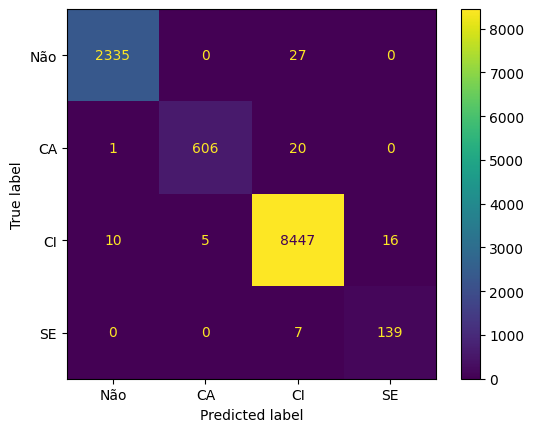

In [21]:
# Recuperação do dataset completo e divisão em treino e teste
X = df['descricao_lematizada']
y = df['categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
y_train = y_train.map({'Não': 0, 'CA': 1, 'CI': 2, 'SE': 3})
y_test = y_test.map({'Não': 0, 'CA': 1, 'CI': 2, 'SE': 3})

# Ajuste do modelo e predição
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Avaliação
print("F1-Score balanceado:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Não', 'CA', 'CI', 'SE'])

### 2.3. Análise das predições do modelo

In [22]:
# Cálculo das probabilidades de cada classe
prob_pred = best_model.predict_proba(X_test)

# Construção de dataframe para conferência das previsões e respectivas probabilidades
df_check = pd.DataFrame(X_test)
df_check['target'] = y_test
df_check['prediction'] = y_pred
df_check['target'] = df_check['target'].map({0: 'Não', 1: 'CA', 2: 'CI', 3: 'SE'})
df_check['prediction'] = df_check['prediction'].map({0: 'Não', 1: 'CA', 2: 'CI', 3: 'SE'})
df_check['prob_CA'] = np.round(prob_pred[0:,0],6).tolist()
df_check['prob_CI'] = np.round(prob_pred[0:,1],6).tolist()
df_check['prob_Não'] = np.round(prob_pred[0:,2],6).tolist()
df_check['prob_SE'] = np.round(prob_pred[0:,3],6).tolist()

# Listar as previsões erradas
df_error = df_check[df_check['target'] != df_check['prediction']]
print('Quantidade de previsões erradas:', df_error.shape[0])
df_error

Quantidade de previsões erradas: 86


,descricao_lematizada,target,prediction,prob_CA,prob_CI,prob_Não,prob_SE
31073,auxilio financeiro cobrir despesa compra medicamento,Não,CI,0.303638,0.007764,0.686702,0.001895
6367,ser frete voadeira transportar técnico pedagógico visitar escola fundamental localidade Santa Maria andirobal rua fogo joana per umarizal araquembaua baixinho,CI,CA,0.003996,0.800966,0.194793,0.000245
32130,carro alugar educação de este,Não,CI,0.003351,0.006748,0.989589,0.000313
685,logisticar saúde de este municipio,CA,CI,0.003300,0.001964,0.994410,0.000326
10367,contribuição financeiro conceder custear despesa taxa arbitragemo fefuspa onde acontecerar jogo selecao baionense futsal contra selecao Goianesia sera realizar Ginasio higino Ramos de este municipio,CI,Não,0.650290,0.004236,0.344693,0.000782
...,...,...,...,...,...,...,...
11414,ser fornecimento xerox documento necessidade sec exec fazendo,CI,Não,0.933051,0.001890,0.064828,0.000230
27256,digitador setor contábil relacionar rede,CI,SE,0.002095,0.000933,0.472824,0.524148
8,motorista veiculo pesado lotar saber,CA,CI,0.018565,0.351469,0.628657,0.001308
25327,digitador setor contábil relacionar rede,CI,SE,0.002095,0.000933,0.472824,0.524148


## 3. Classificação em 2 etapas (primeiro fato gerador, depois categoria)

### 3.1. Classificação de fato gerador

#### 3.1.1. Otimização de hiperparâmetros

In [23]:
%%time
# Dataframe de teste para determinação das melhores técnicas de processamento de texto e melhores hyperparâmetros.
# O método sample estratifica o dataframe proporcionalmente às classes.
df_sample = df.sample(8000, random_state=42)
df_train, df_test = train_test_split(df_sample, test_size=0.3, stratify=df_sample[['fato_gerador', 'categoria']], random_state=42)

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['fato_gerador']
X_test, y_test = df_test['descricao_lematizada'], df_test['fato_gerador']
y_train = y_train.map({'Não': 0, 'Sim': 1})
y_test = y_test.map({'Não': 0, 'Sim': 1})

# Transformação TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

# Otimização dos hiperparâmetros do XGBClassifier com Optuna
# Função objetivo de otimização
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "verbosity": 0,
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return f1

# Otimização
sampler = TPESampler(seed=42)
study_1 = optuna.create_study(sampler=sampler, direction='maximize')
study_1.optimize(objective, n_trials=30)

# Pipeline do modelo com os melhores hiperparâmetros
best_model_1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', XGBClassifier(**study_1.best_params))
])

# Resultado
print(f'Melhores hiperparâmetros: {study_1.best_params}')
print(f'Melhor F1-Score: {study_1.best_value:.6f}')

[I 2024-10-24 22:21:21,640] A new study created in memory with name: no-name-f65a19a4-0581-49d4-afc3-750e22531ec8
[I 2024-10-24 22:21:22,358] Trial 0 finished with value: 0.9928809607447088 and parameters: {'n_estimators': 400, 'learning_rate': 0.07969454818643935, 'max_depth': 8, 'subsample': 0.6187255599871848, 'colsample_bytree': 0.19821770842031466, 'min_child_weight': 4}. Best is trial 0 with value: 0.9928809607447088.
[I 2024-10-24 22:21:22,515] Trial 1 finished with value: 0.94033213382988 and parameters: {'n_estimators': 100, 'learning_rate': 0.05399484409787434, 'max_depth': 7, 'subsample': 0.7226689489062432, 'colsample_bytree': 0.06955526958101232, 'min_child_weight': 20}. Best is trial 0 with value: 0.9928809607447088.
[I 2024-10-24 22:21:23,620] Trial 2 finished with value: 0.9172207629054363 and parameters: {'n_estimators': 900, 'learning_rate': 0.0026587543983272706, 'max_depth': 2, 'subsample': 0.22423428436076215, 'colsample_bytree': 0.3390301308115608, 'min_child_weig

Melhores hiperparâmetros: {'n_estimators': 700, 'learning_rate': 0.04394909714042285, 'max_depth': 3, 'subsample': 0.9590184798453538, 'colsample_bytree': 0.23355816926793227, 'min_child_weight': 1}
Melhor F1-Score: 0.994560
CPU times: user 1min 22s, sys: 516 ms, total: 1min 22s
Wall time: 50.3 s


#### 3.1.2. Avaliação do modelo

F1-Score balanceado: 0.9966355640483412
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2362
           1       1.00      1.00      1.00      9251

    accuracy                           1.00     11613
   macro avg       1.00      0.99      0.99     11613
weighted avg       1.00      1.00      1.00     11613



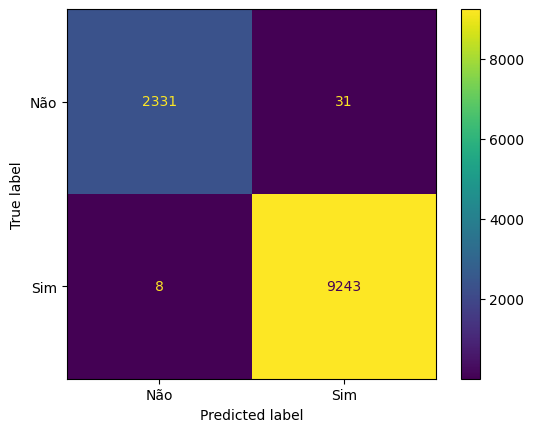

In [24]:
# Recuperação do dataset completo e divisão em treino e teste
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['fato_gerador']
X_test, y_test = df_test['descricao_lematizada'], df_test['fato_gerador']
y_train = y_train.map({'Não': 0, 'Sim': 1})
y_test = y_test.map({'Não': 0, 'Sim': 1})

# Ajuste do modelo e predição
best_model_1.fit(X_train, y_train)
y_pred = best_model_1.predict(X_test)

# Avaliação
print("F1-Score balanceado:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Não', 'Sim'])

### 3.2. Classificação de categoria

#### 3.2.1. Otimização de hiperparâmetros

In [25]:
%%time
# Dataframe de teste para determinação dos melhores hyperparâmetros.
# O método sample estratifica o dataframe proporcionalmente às classes.
df_sample = df.sample(8000, random_state=42)
df_sample = df_sample[df_sample['fato_gerador'] == 'Sim']
df_train, df_test = train_test_split(df_sample, test_size=0.3, stratify=df_sample[['fato_gerador', 'categoria']], random_state=42)

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['categoria']
X_test, y_test = df_test['descricao_lematizada'], df_test['categoria']
y_train = y_train.map({'CA': 0, 'CI': 1, 'SE': 2})
y_test = y_test.map({'CA': 0, 'CI': 1, 'SE': 2})

# Transformação TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

# Otimização dos hiperparâmetros do XGBClassifier com Optuna
# Função objetivo de otimização
def objective(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": 3,
        "verbosity": 0,
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return f1

# Otimização
sampler = TPESampler(seed=42)
study_2 = optuna.create_study(sampler=sampler, direction='maximize')
study_2.optimize(objective, n_trials=30)

# Pipeline do modelo com os melhores hiperparâmetros
best_model_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', XGBClassifier(**study_2.best_params))
])

# Resultado
print(f'Melhores hiperparâmetros: {study_2.best_params}')
print(f'Melhor F1-Score: {study_2.best_value:.6f}')

[I 2024-10-24 22:22:20,513] A new study created in memory with name: no-name-5898a8bc-9932-42ef-b253-2ad3c8a03822
[I 2024-10-24 22:22:22,543] Trial 0 finished with value: 0.9838200799847923 and parameters: {'n_estimators': 400, 'learning_rate': 0.07969454818643935, 'max_depth': 8, 'subsample': 0.6187255599871848, 'colsample_bytree': 0.19821770842031466, 'min_child_weight': 4}. Best is trial 0 with value: 0.9838200799847923.
[I 2024-10-24 22:22:22,862] Trial 1 finished with value: 0.8963411001056515 and parameters: {'n_estimators': 100, 'learning_rate': 0.05399484409787434, 'max_depth': 7, 'subsample': 0.7226689489062432, 'colsample_bytree': 0.06955526958101232, 'min_child_weight': 20}. Best is trial 0 with value: 0.9838200799847923.
[I 2024-10-24 22:22:25,509] Trial 2 finished with value: 0.9012712143913908 and parameters: {'n_estimators': 900, 'learning_rate': 0.0026587543983272706, 'max_depth': 2, 'subsample': 0.22423428436076215, 'colsample_bytree': 0.3390301308115608, 'min_child_we

Melhores hiperparâmetros: {'n_estimators': 1000, 'learning_rate': 0.022366299482641024, 'max_depth': 4, 'subsample': 0.45532240233007065, 'colsample_bytree': 0.6856179184572162, 'min_child_weight': 1}
Melhor F1-Score: 0.987110
CPU times: user 6min 5s, sys: 1.94 s, total: 6min 7s
Wall time: 3min 37s


#### 3.2.2. Avaliação do modelo

F1-Score balanceado: 0.9948379685278118
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       627
           1       1.00      1.00      1.00      8478
           2       0.89      0.94      0.91       146

    accuracy                           0.99      9251
   macro avg       0.96      0.97      0.96      9251
weighted avg       0.99      0.99      0.99      9251



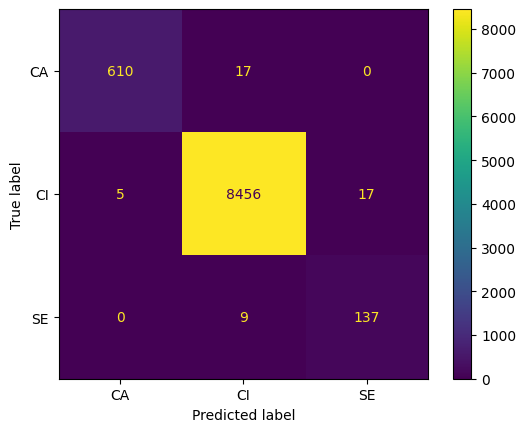

In [26]:
# Recuperação do dataset completo, filtro das observações fato_gerador = 1
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)
df_train = df_train[df_train['fato_gerador'] == 'Sim']
df_test = df_test[df_test['fato_gerador'] == 'Sim']

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['categoria']
X_test, y_test = df_test['descricao_lematizada'], df_test['categoria']
y_train = y_train.map({'CA': 0, 'CI': 1, 'SE': 2})
y_test = y_test.map({'CA': 0, 'CI': 1, 'SE': 2})

# Ajuste do modelo e predição
best_model_2.fit(X_train, y_train)
y_pred = best_model_2.predict(X_test)

# Avaliação
print("F1-Score balanceado:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['CA', 'CI', 'SE'])

### 3.3. Combinação dos classificadores de cada etapa
> O modelo best_model_1 faz a classificação de fato gerador.

> O modelo best_model_2 faz a classificação de categoria.

In [27]:
# Recuperação do dataset completo e divisão em treino e teste
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)

In [28]:
df_test['fg_pred'] = best_model_1.predict(df_test['descricao_lematizada'])
df_test['fg_pred'] = df_test['fg_pred'].map({0: 'Não', 1: 'Sim'})

df_test_sim = df_test[df_test['fg_pred'] == 'Sim']
df_test_sim['cat_pred'] = best_model_2.predict(df_test_sim['descricao_lematizada'])
df_test_sim['cat_pred'] = df_test_sim['cat_pred'].map({0: 'CA', 1: 'CI', 2: 'SE'})

df_test_nao = df_test[df_test['fg_pred'] == 'Não']
df_test_nao['cat_pred'] = 'Não'

df_test = pd.concat([df_test_sim, df_test_nao], ignore_index=True)

<ipython-input-28-4718909a5d13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sim['cat_pred'] = best_model_2.predict(df_test_sim['descricao_lematizada'])
<ipython-input-28-4718909a5d13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sim['cat_pred'] = df_test_sim['cat_pred'].map({0: 'CA', 1: 'CI', 2: 'SE'})
<ipython-input-28-4718909a5d13>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


F1-Score balanceado: 0.9926990806746734
              precision    recall  f1-score   support

          CA       0.99      0.97      0.98       627
          CI       0.99      1.00      1.00      8478
         Não       1.00      0.99      0.99      2362
          SE       0.89      0.94      0.91       146

    accuracy                           0.99     11613
   macro avg       0.97      0.97      0.97     11613
weighted avg       0.99      0.99      0.99     11613



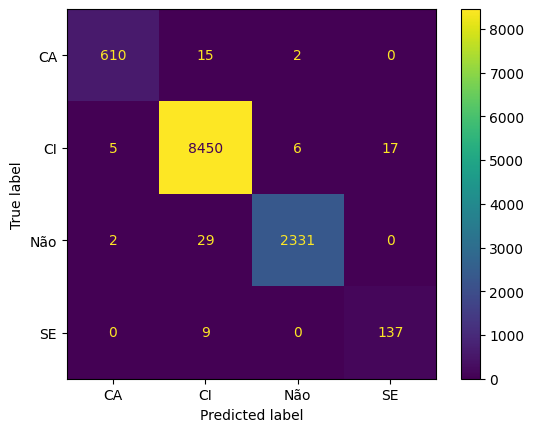

In [29]:
# Métricas de avaliação da predição
print("F1-Score balanceado:", f1_score(df_test['categoria'], df_test['cat_pred'], average='weighted'))
print(classification_report(df_test['categoria'], df_test['cat_pred']))
ConfusionMatrixDisplay.from_predictions(df_test['categoria'], df_test['cat_pred'])

In [30]:
# Listar as previsões erradas
df_error = df_test[df_test['categoria'] != df_test['cat_pred']]
print('Quantidade de previsões erradas:', df_error.shape[0])
df_error

Quantidade de previsões erradas: 85


,descricao_lematizada,fato_gerador,categoria,fg_pred,cat_pred
12,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
347,transporte tubo concreto armar usar obra infraestrutura em este cidade,Sim,CA,Sim,CI
444,aluquel social,Não,Não,Sim,CI
504,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
624,transporte tubo concreto armar usar obra infraestrutura em este cidade,Sim,CA,Sim,CI
...,...,...,...,...,...
10701,ser marceneiro fornecimento material divisoria casa onde ir funcionar sede seab urbanismo,Sim,CI,Não,Não
10789,ser locação levar trazer correspondencia saude baiao regional,Sim,CA,Não,Não
11256,ser pintura reforma banheiro imovel destinar funcionamento quartel policiar militar,Sim,CI,Não,Não
11438,fornecimento bufe gabinete,Sim,CI,Não,Não


## 4. Exportação dos melhores modelos

In [31]:
# Exportação dos melhores modelos
joblib.dump(best_model, '/content/drive/My Drive/projeto classificacao de lancamento/modelos/xgb_best_model.pkl')
joblib.dump(best_model_1, '/content/drive/My Drive/projeto classificacao de lancamento/modelos/xgb_best_model_1.pkl')
joblib.dump(best_model_2, '/content/drive/My Drive/projeto classificacao de lancamento/modelos/xgb_best_model_2.pkl')

['/content/drive/My Drive/projeto classificacao de lancamento/modelos/xgb_best_model_2.pkl']

## 5. Avaliação do melhor modelo com RepeatedStratifiedKFold

In [ ]:
# Importa melhor modelo com 1 etapa
best_model = joblib.load('/content/drive/My Drive/projeto classificacao de lancamento/modelos/xgb_best_model.pkl')

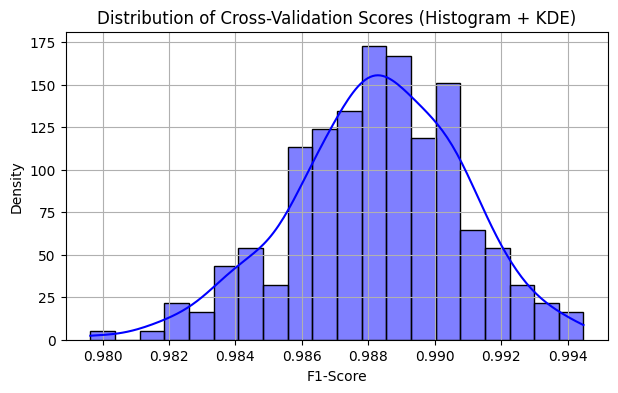

F1-Score médio: 0.988231
Desvio padrão: 0.002552


In [ ]:
df_sample = df.sample(8000, random_state=42)
X = df_sample['descricao_lematizada']
y = df_sample['categoria']
y = y.map({'Não': 0, 'CA': 1, 'CI': 2, 'SE': 3})

# Definição da estratégia de validação cruzada com 5 folds e 20 repetições e avaliação do modelo
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=50, random_state=42)
scores = cross_val_score(best_model, X, y, cv=cv, scoring='f1_weighted')

# Plotando o histograma dos scores com curva de densidade (KDE)
plt.figure(figsize=(7, 4))
sns.histplot(scores, kde=True, bins=20, color='blue', stat='density')
plt.title('Distribution of Cross-Validation Scores (Histogram + KDE)')
plt.xlabel('F1-Score')
plt.ylabel('Density')
plt.grid(True)
plt.show()
print(f"F1-Score médio: {np.mean(scores):.6f}")
print(f"Desvio padrão: {np.std(scores):.6f}")